# Understanding Selection Functions in the presence of dust extinction

The selection functions of stellar surveys are usually defined in the simplest observable available. Since we can measure the apparent brightness and colour of stars very easily and we have many close to complete catalogues of these that are readily available to make target selections from, it is common that target selections are made in these observables.

In [1]:
import os
os.environ['RESULTS_VERS'] = "l33"
import numpy as np
import apogee.select as apsel
import apogee.tools.read as apread
import pickle
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.integrate import quad
import isodist
from isodist import imf as mimf
import tqdm
import isochrones as iso
import matplotlib.pyplot as plt
import mwdust
import healpy

plt.style.use('regular')

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

/mnt/scratch-lustre/RAID-CITA/tedmackereth/opt/python/venv-3.6.4/lib/python3.6/site-packages/galpy-1.8.0.dev0-py3.6-linux-x86_64.egg/galpy/util/bovy_plot.py:5: FutureWarning: galpy.util.bovy_plot is being deprecated in favor of galpy.util.plot; functions inside of this module have also changed name, but all functions still exist; please switch to the new import and new function names, because the old import and function names will be removed in v1.9
  warnings.warn('galpy.util.bovy_plot is being deprecated in favor of galpy.util.plot; functions inside of this module have also changed name, but all functions still exist; please switch to the new import and new function names, because the old import and function names will be removed in v1.9',FutureWarning)

/mnt/scratch-lustre/RAID-CITA/tedmackereth/opt/python/venv-3.6.4/lib/python3.6/site-packages/galpy-1.8.0.dev0-py3.6-linux-x86_64.egg/galpy/util/bovy_coords.py:6: FutureWarning: galpy.util.bovy_coords is being deprecated in favor of g

The very first step in generating our mock data is to sample points in a single APOGEE-like pointing on the sky. We will assume that the stellar density is constant, so we just need to sample uniformly in a cone.

A few general geometric formulae (not all get used here, this was just for my own reference!)

$$\pi b^2 = A$$

$$\Omega = A / h^2$$

$$\Omega = \frac{\pi b^2}{h^2}$$

$$\Omega = 4\pi\ \sin^2{(\theta/2)}$$

$$\theta = 2\sin^{-2}{\frac{\Omega}{4\pi}}$$

$$ b = \sqrt{\frac{\Omega h^2}{\pi}} $$

$$V = \pi b^2 h/3$$

Random angles on spherical cap:

$$ \phi_r = 2\pi\ r_1 $$
$$ \theta_r = \cos^{-1}{((1-\cos{\theta})r_2 + \cos{\theta})}$$

Volume of spherical cap:

$${ V={\frac {\pi }{3}}r^{3}(2+\cos \theta )(1-\cos \theta )^{2}}$$

We now put these formulae to work in python functions:

In [2]:
_DEGTORAD = (np.pi/180.)
_RADTODEG = (180./np.pi)

def sample_box(N, xrange=[0.,3.], yrange=[-1,1], zrange=[-1,1]):
    """ sample random points in a box """
    randx = (np.random.rand(N)*(xrange[1]-xrange[0]))+xrange[0]
    randy = (np.random.rand(N)*(yrange[1]-yrange[0]))+yrange[0]
    randz = (np.random.rand(N)*(zrange[1]-zrange[0]))+zrange[0]
    return randx, randy, randz

def sample_cone(N, height=2., solid_angle=2.0, return_ts=False):
    """ sample random points in a cone with a flat cap """
    b = np.sqrt((solid_angle*height**2)/np.pi)
    a = height*np.random.rand(N)**(1/3)
    r = ( b / height ) * a * np.random.rand(N)
    t = 2* np.pi*np.random.rand(N)
    
    x = r*np.cos(t)
    y = a
    z = r*np.sin(t)
    if return_ts:
        return x,y,z,t
    return x, y, z


def sample_cone_spher(N, l=0., b=90., height=2., solid_angle=1, return_spherical=False):
    """ sample N uniform density points in a cone of given solid angle with a spherical cap (i.e. like a telescope pointing through a field of constant density)
        this function also makes the transformation to a given galactic longitude (l) and latitiude (b).
    """
    fieldvec = np.array([np.sin((b-90)*_DEGTORAD)*np.cos(l*_DEGTORAD), np.sin((b-90)*_DEGTORAD)*np.sin(l*_DEGTORAD), np.cos((b-90)*_DEGTORAD)])
    opening_angle = 2*np.arcsin(np.sqrt(solid_angle/(4*np.pi)))

    z = np.random.rand(N) * (1 - np.cos(opening_angle)) + np.cos(opening_angle)
    phi = np.random.rand(N) * 2 * np.pi
    x = np.sqrt(1-z**2)*np.cos(phi)
    y = np.sqrt(1-z**2)*np.sin(phi)
    
    rot_axis = np.cross(np.array([0,0,1]), fieldvec)
    rot_axis /= np.linalg.norm(rot_axis)
    rot_angle = np.arccos(np.dot(np.array([0,0,1]),fieldvec))
    crossMatrix = np.array([[0, -rot_axis[2], rot_axis[1]],[rot_axis[2], 0, -rot_axis[0]],[-rot_axis[1], rot_axis[0], 0]])
    
    R = np.cos(rot_angle)*np.eye(3) + np.sin(rot_angle)*crossMatrix + (1-np.cos(rot_angle))*np.outer(rot_axis,rot_axis.T)
    r = np.dstack([x, y, z])[0]
    r_t = np.dot(r,R)
    if not return_spherical:
        return r_t
    #transform to spherical
    r = np.random.rand(len(r_t))**(1/3)*height
    theta = np.arctan2(np.linalg.norm(r_t[:,:2], axis=1),r_t[:,2])
    phi = np.arctan2(r_t[:,1], r_t[:,0])
    r_t = np.dstack([r,theta,phi])[0]
    return r_t

def V_cone(d,solid_angle):
    """ volume of flat cap cone """
    b = np.sqrt((solid_angle*d**2)/np.pi)
    return np.pi*b**2*d/3.

def V_cap(d, solid_angle):
    """ volume of a spherical cap """
    theta = omega_to_theta(solid_angle)
    return np.pi/3*d**3*(2+np.cos(theta))*(1-np.cos(theta))**2

def V_field(d, solid_angle):
    """ volume of flat cap cone plus spherical cap """
    return V_cone(d,solid_angle)+V_cap(d,solid_angle)

def omega_to_theta(omega):
    """ from solid angle to radius """
    return 2*np.arcsin(np.sqrt(omega/(4*np.pi)))

def theta_to_omega(theta):
    """ from radius to solid angle """
    return 4*np.pi*np.sin(theta/2)**2

The other ingredients that we will need later are some representation of dust extinction in APOGEE fields, and a model for the stellar population of the MW. For these we have a 3D dust map of the galaxy, accessed through the `mwdust` package and the PARSEC isochrones, which we already have downloaded and compiled, accessed via helper functions in `isochrones.py`.

We'll load these now, before we get stuck in, to make sure everything is working properly:

In [3]:
dmap = mwdust.Combined19('2MASS H')
isogrid = iso.newgrid()

With these loaded, lets test our sampling methods from above to ensure that the sampled points really do have constant density:

the mean density is 12155890.161817877 stars per kpc^3


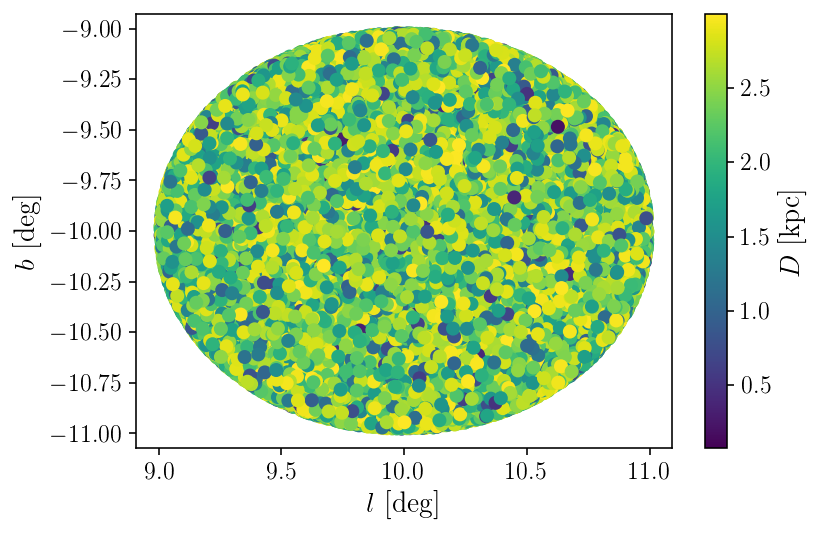

In [4]:
# set the number of points to sample
Nsamp = 100000
# pick a distance limit plus some random l,b on the sky. 
dist,l,b = 3,10, -10
# we'll set the solid angle of the pointing to ~3 degrees
solid_angle = 3*_DEGTORAD**2

#compute the mean density per kpc^3 given this many points for later
meandens = Nsamp / V_field(dist,solid_angle)
print('the mean density is %s stars per kpc^3' % meandens)

#now sample points at this l, b and d range
rands = sample_cone_spher(Nsamp, l=l, b=b, height=dist, solid_angle=solid_angle, return_spherical=True)

#plot the on-sky distribution:
plt.scatter(rands[:,2]*_RADTODEG, 90-rands[:,1]*_RADTODEG, c=rands[:,0])
plt.xlabel(r'$l\ \mathrm{[deg]}$')
plt.ylabel(r'$b\ \mathrm{[deg]}$')
plt.colorbar(label=r'$D\ \mathrm{[kpc]}$')

the on sky distribution looks right - it's pointing in the right place. The distance scale is correct too, so thats good. What about the mean density?

Text(0, 0.5, '$\\nu_*\\ \\mathrm{[star\\ kpc^{-3}]}$')

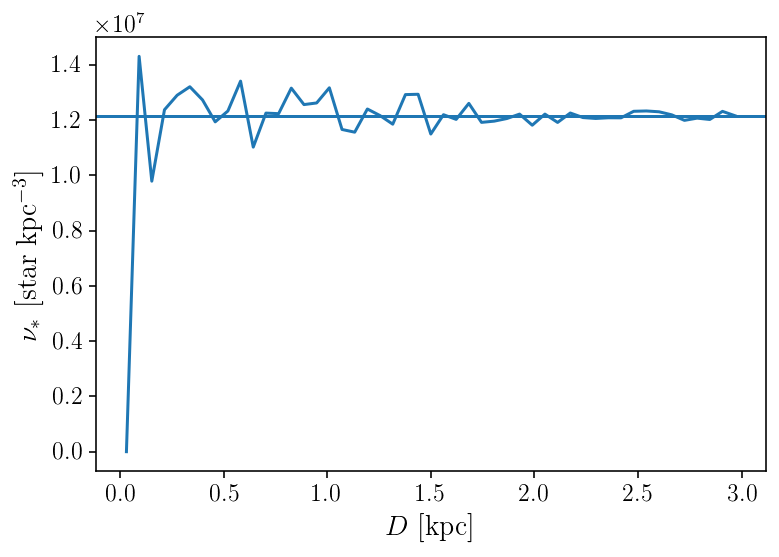

In [5]:
#bins in distance
rs = np.linspace(0.,dist,50)
#volume at each bin
vols = V_field(rs,solid_angle)
#number of points in each bin
n, bins = np.histogram(rands[:,0], bins=rs)
#volume in each bin
Vdiff = vols[1:]-vols[:-1]
#bin centers
rcenters = (rs[1:]+rs[:-1])/2.
# plot
plt.plot(rcenters, n/Vdiff,)
plt.axhline(meandens)
plt.xlabel(r'$D\ \mathrm{[kpc]}$')
plt.ylabel(r'$\nu_*\ \mathrm{[star\ kpc^{-3}]}$')

we get a bit of noise from the sampling but overall the density converges to a constant which matches the one that we expected from earlier!

Ok - so we can sample in a field. Let's start simple and assume there is no extinction, we just have an APOGEE-like pointing populated with samples from our set of isochrones (fake stars). The next bit will show you how this sampling works, using helper functions from `isochrones.py`.

## No dust

First we need to include mock stellar properties (magnitude) in our samples from above. We do this by using the `sampleiso` function from `isochrones.py`. This essentially takes samples from the isochrone tracks weighted by the stellar initial mass function IMF. See below:

In [6]:
# draw Nsamp samples from isogrid
samples = iso.sampleiso(Nsamp, isogrid, newgrid=True)
print(samples[:5])

   Zini      MH   logAge      Mini     ... W2mag W3mag W4mag       weights      
---------- ----- -------- ------------ ... ----- ----- ----- -------------------
 0.0024432  -0.8 10.00432 0.3348424733 ... 6.339 6.299 5.963 0.10874581340000011
0.00097797  -1.2  9.95904 0.1599999964 ... 7.764 7.713  7.38  0.1253029108000001
  0.055277  0.65  9.85126 0.1000000015 ... 9.374 9.138 8.761        1.5704020262
  0.030851  0.35 10.04532  0.313595742 ... 6.655 6.524  6.16 0.17143893239999963
0.00069308 -1.35 10.04532 0.6000000238 ...  4.59 4.622 4.335 0.04076385490000023


Looks like we have stellar properties. What does the CMD look like?

Text(0, 0.5, '$M_H$')

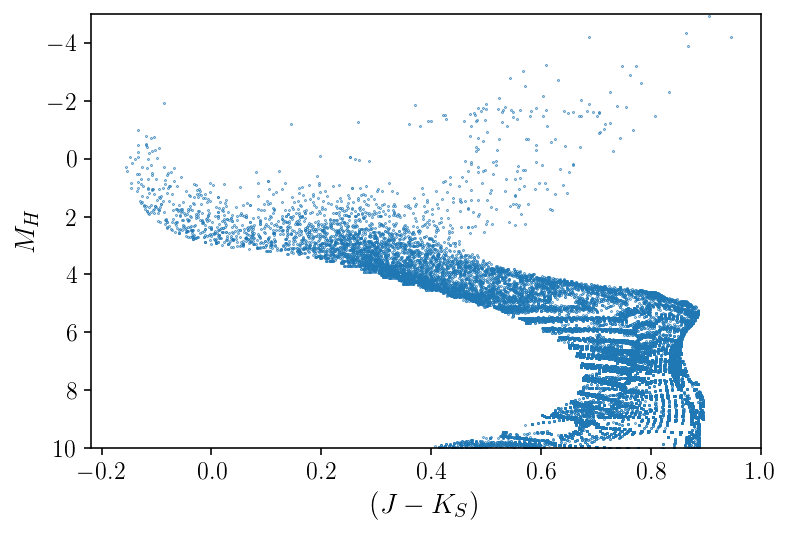

In [7]:
plt.scatter(samples['Jmag']-samples['Ksmag'], samples['Hmag'], s=0.1,)
plt.ylim(10,-5)
plt.xlabel(r'$(J-K_S)$')
plt.ylabel(r'$M_H$')

great! we can see a main sequence, a turn off, an RGB and the emerging Red Clump at $M_H \simeq -2$. But we know that APOGEE actually observes mainly RGB stars, so how can we limit the samples to an APOGEE like sampling? Simple, we just add a surface gravity $\log(g)$ cut before we sample:

Text(0, 0.5, '$M_H$')

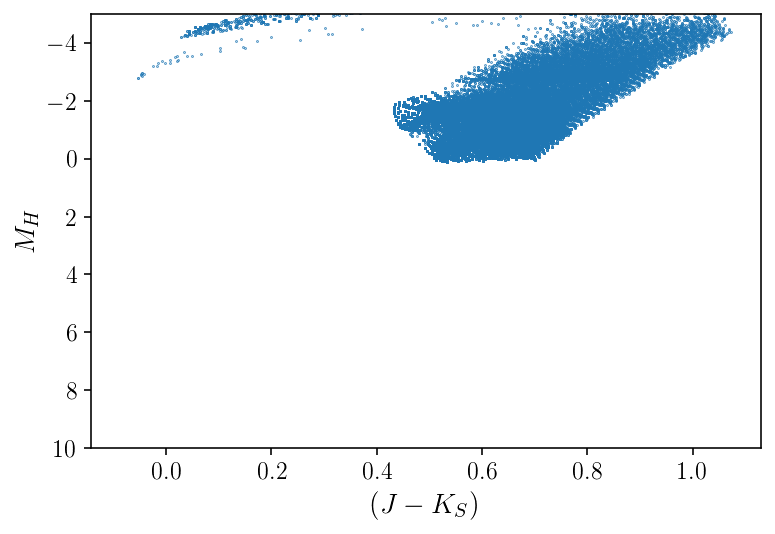

In [8]:
# make a mask for the isochrones (we'll mask logg and also metallicity to be sure we know what we have in our samples):
mask = (isogrid['logg'] > 1) & (isogrid['logg'] <= 3) & (isogrid['MH'] > -1.) & (isogrid['MH'] <= 0.5)
# draw Nsamp samples from isogrid, now applying the mask
samples = iso.sampleiso(Nsamp, isogrid[mask], newgrid=True)
#plot again
plt.scatter(samples['Jmag']-samples['Ksmag'], samples['Hmag'], s=0.1,)
plt.ylim(10,-5)
plt.xlabel(r'$(J-K_S)$')
plt.ylabel(r'$M_H$')

Great! now you can see how we have densely sampled the RGB and some other rarer stellar populations that could conceivably enter the APOGEE selection.

Now we compute the distance modulus for each sample and apply it to get the apparent magnitudes (which is what the APOGEE selection function is based in!):

Text(0, 0.5, '$N$')

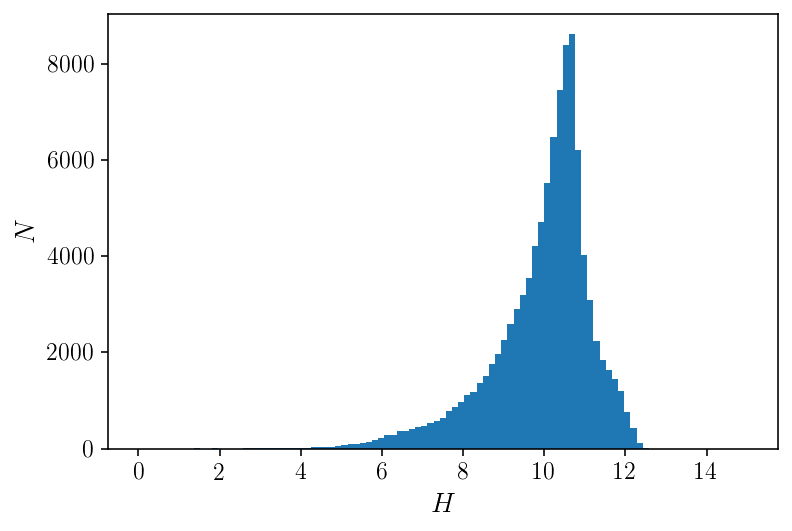

In [9]:
distmods = 5*np.log10(rands[:,0]*1e3)-5
hmag = samples['Hmag']+distmods
#plot a histogram
plt.hist(hmag, bins = np.linspace(0.,15,100))
plt.xlabel(r'$H$')
plt.ylabel(r'$N$')

for this very simplistic case, we'll make our function that defines the selection fraction only as a function of the apparent magnitude. By evaluating this function we get the selection fraction for any H mag. This is almost exactly replicating what the APOGEE target selection did (only they selected from the real 2MASS catalogue in each field!)

Text(0, 0.5, 'selection fraction')

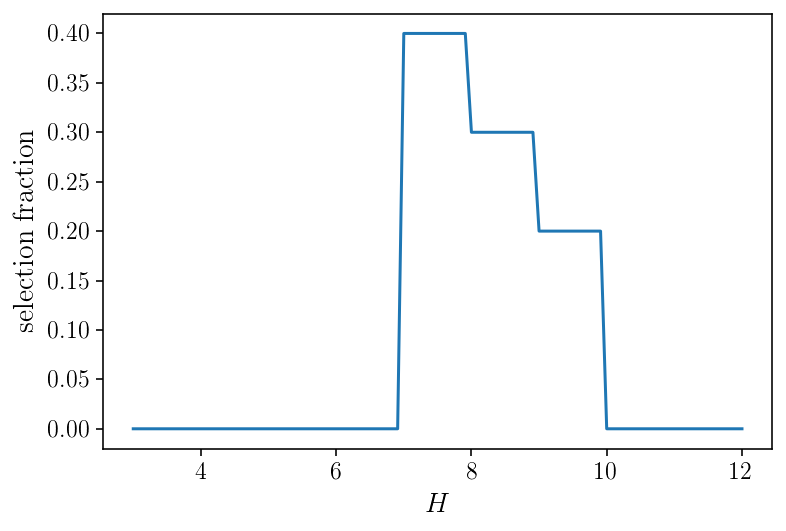

In [10]:
#define the Hmag bins and selection fractions
sf_mags = np.array([7.,8.,9.,10.])
sf_vals = np.array([0.4,0.3,0.2])

def mock_sf(mag, limits=sf_mags, vals=sf_vals):
    inds = np.digitize(mag, sf_mags) - 1
    inside = (inds != -1) & (inds != (len(sf_mags)-1))

    sf_at_mags = np.zeros(len(mag))
    sf_at_mags[inside] = sf_vals[inds[inside]]
    return sf_at_mags
mags = np.linspace(3,12.,100)

plt.plot(mags, mock_sf(mags))
plt.xlabel(r'$H$')
plt.ylabel(r'selection fraction')

Looks nice! we can apply this selection function to our mock data by doing a rejection sampling. We draw uniform random numbers against the selection fraction, and the points survive if the random number is less than the selection fraction for their $H$:

In [11]:
accept = np.random.rand(len(hmag)) < mock_sf(hmag) 
print(sum(accept)/len(accept))

0.09413


We select roughly 10% of the points. How does this change our distance distribution?

Text(0, 0.5, '$f$')

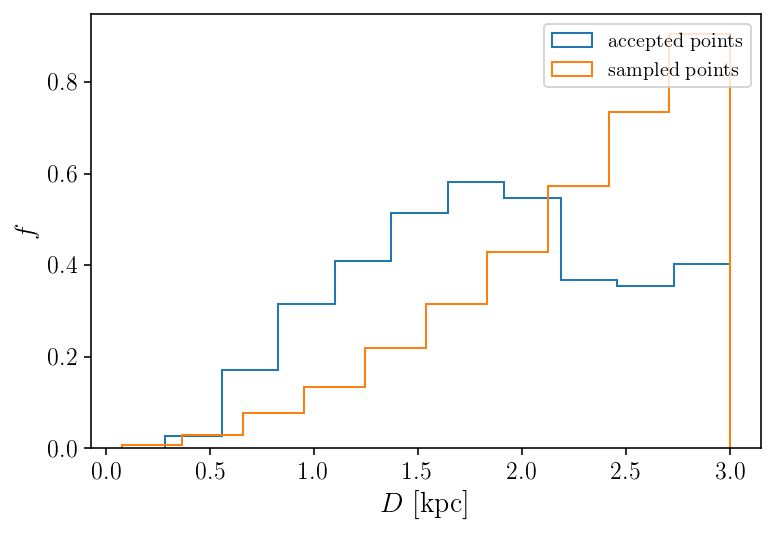

In [12]:
plt.hist(rands[:,0][accept], density=True, histtype='step', label=r'accepted points')
plt.hist(rands[:,0], density=True, histtype='step', label=r'sampled points')
plt.legend()
plt.xlabel(r'$D\ \mathrm{[kpc]}$')
plt.ylabel(r'$f$')

we see that the selection function essentially drops some stars at large distances - this is because these stars are too faint!

We have a selection function in terms of $H$, but ideally need to convert this to a function of $D$ - the 'effective' selection function. This involves performing an integral of the selection function over the stellar population (the $M_H$ distribution) at each distance. We can do this using monte-carlo integration (i.e. averaging SF over all the samples at each distance!):

In [15]:
#distances to compute the effective selection at
ds = np.linspace(0.,dist,100)
distmods = 5*np.log10(ds*1e3)-5
#empty array for the effective selection at each D
eff = np.zeros(len(ds))
#cycle through Ds and find average SF at each D:
for i in range(len(ds)):
    hmag = samples['Hmag']+distmods[i]
    s_f = mock_sf(hmag)
    eff[i] = np.sum(s_f)/len(samples)

/mnt/scratch-lustre/RAID-CITA/tedmackereth/opt/python/venv-3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until



What does this look like as a function of distance?

Text(0, 0.5, 'effective selection fraction')

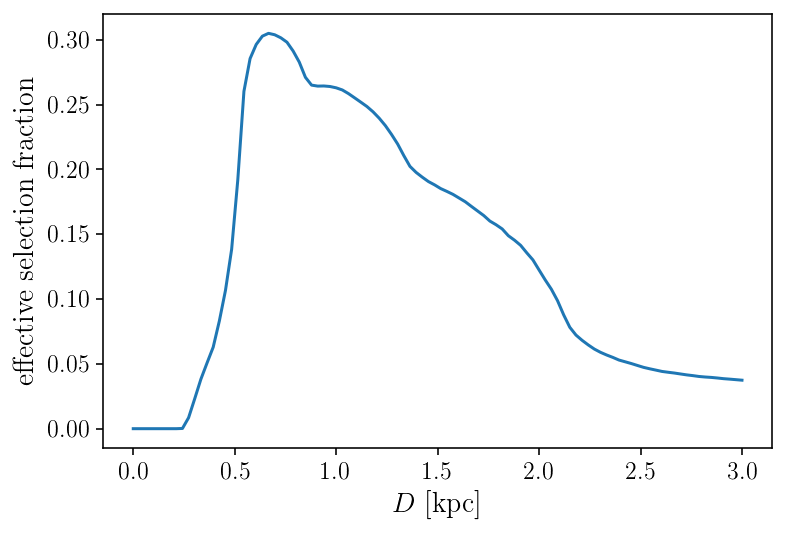

In [16]:
volume = V_field(ds, solid_angle)
vdiff = np.diff(volume, prepend=0)
plt.plot(ds, eff)
plt.xlabel(r'$D\ \mathrm{[kpc]}$')
plt.ylabel(r'effective selection fraction')

So, does our effective selection function predict the correct number of stars as a function of distance?

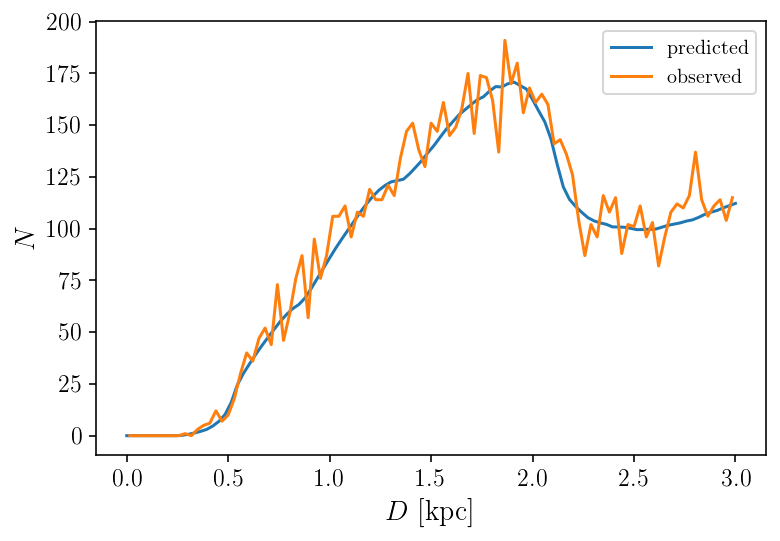

In [17]:
#compute volume in each distance where the effective selection is computed:
volume = V_field(ds, solid_angle)
vdiff = np.diff(volume, prepend=0)
#now the effective selection multiplied by the volume, multiplied by the mean density gives the predicted counts at each D
plt.plot(ds, eff*vdiff*(meandens), label='predicted')
#now make a histogram of the distances as observed by our mock APOGEE:
n, bins = np.histogram(rands[:,0][accept], bins=ds, )
rcenters = (ds[1:]+ds[:-1])/2.
plt.plot(rcenters,n,label='observed')
plt.xlabel(r'$D\ \mathrm{[kpc]}$')
plt.ylabel(r'$N$')
plt.legend()

Looks like if we know the density, we can pretty accurately predict the observations. Notice that the observations are a noisy realisation of the prediction - this is Poisson noise!

You can see from this that we can optimise the density by trying to recreate the data - this is the forward modelling in a nutshell!

We can also see that the data 'predict' the effective selection function:

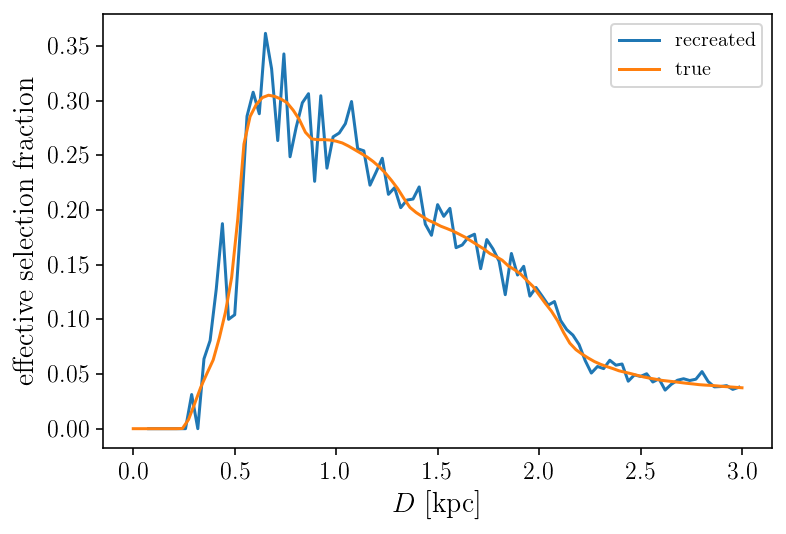

In [18]:
naccept, bins = np.histogram(rands[:,0][accept], bins=ds)
ntot, bins= np.histogram(rands[:,0], bins=ds)

plt.plot(rcenters, naccept/ntot, label='recreated')
plt.plot(ds, eff, label=r'true')

plt.xlabel(r'$D\ \mathrm{[kpc]}$')
plt.ylabel(r'effective selection fraction')
plt.legend()

Pretty good! Ok, so what about if we add in dust extinction? This gets a bit more complex:

## With Dust...

To include the dust, we need to do a slightly more complex integral, that takes into account the observable area ofthe plate (since extinction is filamentary inside the fields!)

In [19]:
Nsamp = 100000
Neffsamp = 2000

#same mask
mask =  (isogrid['logg'] > 1) & (isogrid['logg'] < 3) & (isogrid['MH'] > -1.) & (isogrid['MH'] <= 0.5)

# sample for our mock data and a smaller set for the effective selection function (to speed things up!)
samples = iso.sampleiso(Nsamp, isogrid[mask], newgrid=True)
effsel_samples = iso.sampleiso(Neffsamp, isogrid[mask], newgrid=True)

#set the field parameters again
dist,l,b = 5,10, -10
solid_angle = 6*_DEGTORAD**2

#sample the positions again
meandens = Nsamp / V_field(dist,solid_angle)
print('mean density is %s stars kpc^-3' % meandens)
rands = sample_cone_spher(Nsamp, l=l, b=b, height=dist, solid_angle=solid_angle, return_spherical=True)

sample_l, sample_b, sample_d = rands[:,2]*_RADTODEG, 90-rands[:,1]*_RADTODEG, rands[:,0]


mean density is 1312549.8876076392 stars kpc^-3


Ok, so now we perform the same integral of the selection function at each D, but this time we take the distribution of extinction in the field at each D and integrate over it:

In [20]:

#distance grid
ds = np.linspace(0.,dist,200)
distmods = 5*np.log10(ds*1e3)-5
#we'll store the old effective selection and the new one with dust:
eff = np.zeros(len(ds))
eff_nodust = np.zeros(len(ds))
for i in tqdm.tqdm(range(len(ds))):
    #we use dust_vals_disk method of the dust map to get the extinction distribution on the plate
    pixarea, ah = dmap.dust_vals_disk(l,b,ds[i],omega_to_theta(solid_angle)*_RADTODEG)
    #now compute the apparent hmag
    hmag_nodust = effsel_samples['Hmag']+distmods[i]
    #and the hmag + the dust in each pixel (the array becomes N_samples,N_pixels)
    hmag = np.repeat(effsel_samples['Hmag']+distmods[i],len(ah)).reshape(len(effsel_samples),len(ah))+ah#.ravel()
    #compute the distribution of selection functions
    s_f = mock_sf(hmag.ravel())
    s_f_nodust = mock_sf(hmag_nodust)
    #get the area of each pixel in the same grid
    areas = (np.ones_like(hmag)*pixarea).ravel()
    #compute the area weighted mean of SF for all samples
    eff[i] = np.sum(s_f*areas)/np.sum(areas)
    eff_nodust[i] = np.sum(s_f_nodust)/len(effsel_samples)

/mnt/scratch-lustre/RAID-CITA/tedmackereth/opt/python/venv-3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until



  0%|          | 0/200 [00:00<?, ?it/s]

/mnt/scratch-lustre/RAID-CITA/tedmackereth/opt/python/venv-3.6.4/lib/python3.6/site-packages/mwdust-1.2.dev0-py3.6-linux-x86_64.egg/mwdust/HierarchicalHealpixMap.py:87: RuntimeWarning: divide by zero encountered in log10
  distmod= 5.*numpy.log10(dist)+10.



100%|██████████| 200/200 [08:08<00:00,  2.44s/it]


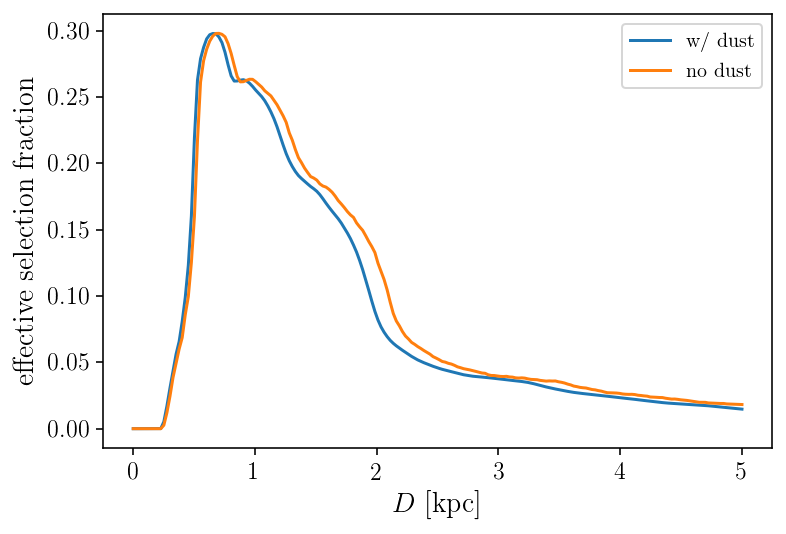

In [21]:
plt.plot(ds, eff, label=r'w/ dust')
plt.plot(ds, eff_nodust, label=r'no dust')

plt.xlabel(r'$D\ \mathrm{[kpc]}$')
plt.ylabel(r'effective selection fraction')
plt.legend()


You can see here how the dust essentially 'squeezes' up the selection function, making it more difficult to see as many stars at larger distances. This is quite a simplified explanation, but it helps with thinking about the effect of dust on this kind of survey.

Before we compare with our samples again (which will require computing extinction for each sample), why dont we add in some more complexity to our selection function. In the case of APOGEE, this complexity is the introduction of colour binning (so the selection function becomes a function of $H$ and also $(J-K_S)$.

# With dust and colour bins

We'll modify our `mock_sf` function so that it takes a magnitude and colour:

Text(0.5, 0, '$(J-K_S)_0\\ \\mathrm{[mag]}$')

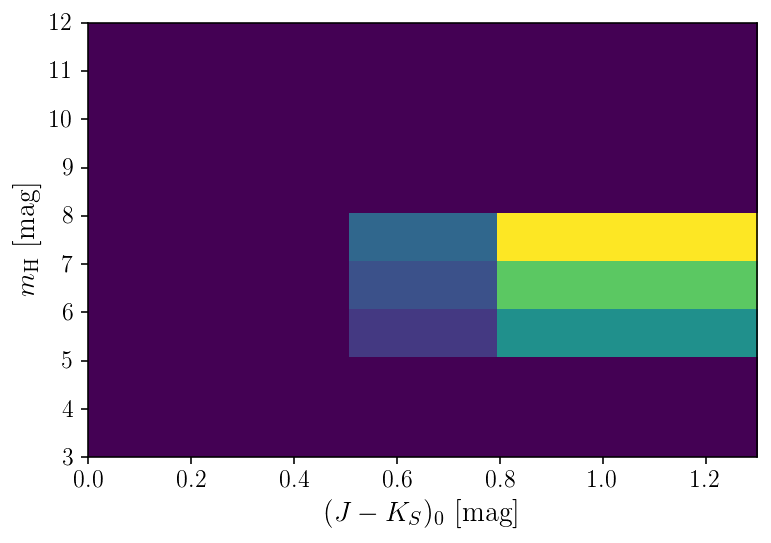

In [22]:
#magnitude limits and selection fractios
sf_mags = np.array([7.,8.,9.,10.])
sf_vals = np.array([0.4,0.3,0.2])
#colour limits and fractions
sf_colours = np.array([0.5,0.8,999.])
sf_cvals = np.array([0.25,0.75])


def mock_sf_cbinned(mag, colour, maglimits=sf_mags, magvals=sf_vals, climits=sf_colours, cvals=sf_cvals):
    maginds = np.digitize(mag, maglimits) - 1
    inside = (maginds != -1) & (maginds != (len(maglimits)-1))

    sf_at_mags = np.zeros(len(mag))
    sf_at_mags[inside] = magvals[maginds[inside]]
    
    cinds = np.digitize(colour, climits) - 1
    inside = (cinds != -1) & (cinds != (len(climits)-1))

    sf_at_cs = np.zeros(len(mag))
    sf_at_cs[inside] = cvals[cinds[inside]]
    
    
    return sf_at_mags*sf_at_cs

#lets plot that in 2D:
minm, maxm, minc, maxc, ng = 3, 12, 0., 1.3, 100
colourmaggrid = np.mgrid[minm:maxm:ng*1j, minc:maxc:ng*1j]
colourmaggrid = colourmaggrid.reshape(2,100*100).T


plt.imshow(mock_sf_cbinned(colourmaggrid[:,0], colourmaggrid[:,1]).reshape(100,100), extent=[minc,maxc,minm,maxm], aspect='auto')
plt.ylabel(r'$m_\mathrm{H}\ \mathrm{[mag]}$')
plt.xlabel(r'$(J-K_S)_0\ \mathrm{[mag]}$')

In [23]:
#redo the integral - include colour!
ds = np.linspace(0.,dist,200)
distmods = 5*np.log10(ds*1e3)-5
eff = np.zeros(len(ds))
eff_nodust = np.zeros(len(ds))
for i in tqdm.tqdm(range(len(ds))):
    pixarea, ah = dmap.dust_vals_disk(l,b,ds[i],omega_to_theta(solid_angle)*_RADTODEG)
    hmag_nodust = effsel_samples['Hmag']+distmods[i]
    jk = effsel_samples['Jmag']-effsel_samples['Ksmag']
    hmag = np.repeat(effsel_samples['Hmag']+distmods[i],len(ah)).reshape(len(effsel_samples),len(ah))+ah
    s_f = mock_sf_cbinned(hmag.ravel(), np.repeat(jk,len(ah)).ravel())
    s_f_nodust = mock_sf_cbinned(hmag_nodust, jk)
    areas = (np.ones_like(hmag)*pixarea).ravel()
    eff[i] = np.sum(s_f*areas)/np.sum(areas)
    eff_nodust[i] = np.sum(s_f_nodust)/len(effsel_samples)

/mnt/scratch-lustre/RAID-CITA/tedmackereth/opt/python/venv-3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until



  0%|          | 0/200 [00:00<?, ?it/s]

/mnt/scratch-lustre/RAID-CITA/tedmackereth/opt/python/venv-3.6.4/lib/python3.6/site-packages/mwdust-1.2.dev0-py3.6-linux-x86_64.egg/mwdust/HierarchicalHealpixMap.py:87: RuntimeWarning: divide by zero encountered in log10
  distmod= 5.*numpy.log10(dist)+10.



100%|██████████| 200/200 [08:11<00:00,  2.46s/it]


[autoreload of typing_extensions failed: Traceback (most recent call last):
  File "/mnt/scratch-lustre/RAID-CITA/tedmackereth/opt/python/venv-3.6.4/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/mnt/scratch-lustre/RAID-CITA/tedmackereth/opt/python/venv-3.6.4/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/mnt/scratch-lustre/RAID-CITA/tedmackereth/opt/python/venv-3.6.4/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/mnt/scratch-lustre/RAID-CITA/tedmackereth/opt/python/venv-3.6.4/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/mnt/scratch-lustre/RAID-CITA/tedmackereth/opt/python/venv-3.6.4/lib/python3.6/site-packages/IPython/extensions/autoreload.py

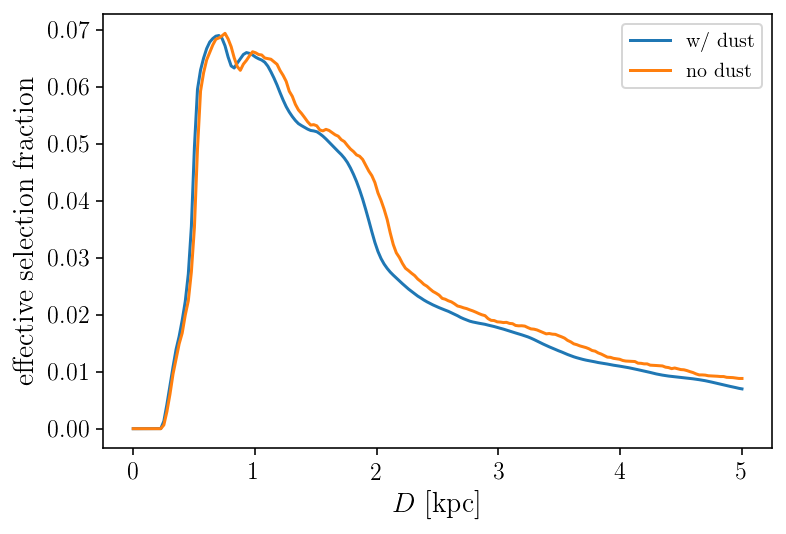

In [24]:
plt.plot(ds, eff, label=r'w/ dust')
plt.plot(ds, eff_nodust, label=r'no dust')

plt.xlabel(r'$D\ \mathrm{[kpc]}$')
plt.ylabel(r'effective selection fraction')
plt.legend()



Ok, so now we have colour binning, and we are including the dust in our effective selection function. Now we need to figure out how much extinction the stars in our mock data are subject to. This could be a time-consuming procedure, so we just pixelate the dustmap and get the extinctions in each pixel and apply them pixel-wise (which is faster, because it uses less queries to the dust map).

In [25]:
def pixelate_and_get_extinction(sample_l, sample_b, sample_d, dmap):
    """ this takes l, b, D samples and gets the extinction from the dustmap"""
    #highest resolution in the map
    maxnside = np.max(dmap._pix_info['nside'])
    #number of pixels in whole sky...
    npix = healpy.pixelfunc.nside2npix(maxnside)
    sample_pixels = healpy.pixelfunc.ang2pix(maxnside, sample_l, sample_b, lonlat=True)
    whichpix = np.unique(sample_pixels)
    distances = []
    sample_inds = []
    nbin = []
    bin_l, bin_b = healpy.pixelfunc.pix2ang(maxnside, whichpix, lonlat=True)
    extinction = np.zeros(len(sample_l))
    for i in tqdm.tqdm(range(len(whichpix))):
        mask = sample_pixels == whichpix[i]
        distances = sample_d[mask]
        ah = dmap(bin_l[i], bin_b[i], distances)
        extinction[mask] = ah  
    return extinction


sample_ah = pixelate_and_get_extinction(sample_l, sample_b, sample_d,dmap)

100%|██████████| 1912/1912 [01:00<00:00, 31.46it/s]


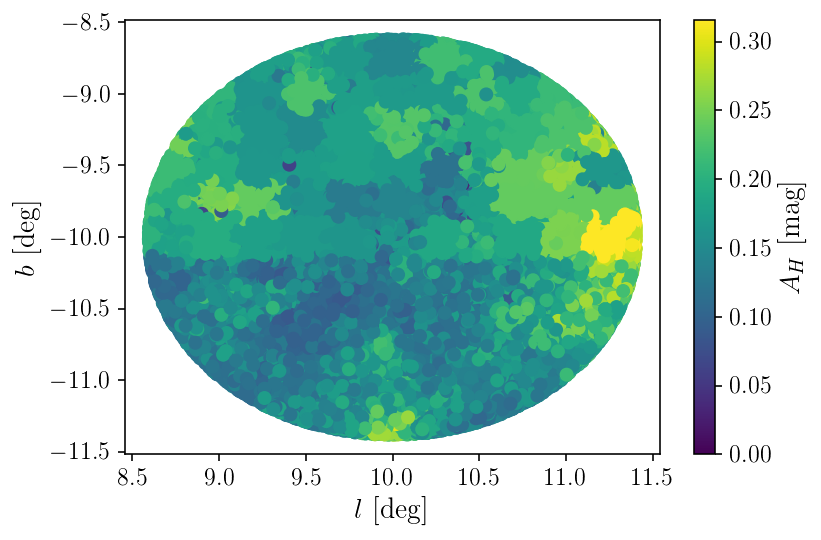

In [26]:
plt.scatter(sample_l, sample_b, c=sample_ah)
plt.xlabel(r'$l\ \mathrm{[deg]}$')
plt.ylabel(r'$b\ \mathrm{[deg]}$')
plt.colorbar(label=r'$A_H\ \mathrm{[mag]}$')

Looks like we have small scale dust extinction!! Lets figure out the magnitude now:

In [27]:
#now we work out the magnitudes and colour including the dust (APOGEE makes selection in de-reddended colour, so we wont apply dust there!)
sample_distmods = 5*np.log10(sample_d*1e3)-5
hmag_dust = samples['Hmag']+sample_distmods+sample_ah
jk_nodust = samples['Jmag']-samples['Ksmag']

#see which samples survive
accept = np.random.rand(len(hmag_dust)) < mock_sf_cbinned(hmag_dust, jk_nodust)
sum(accept)/Nsamp

0.01384

Now we get about 1 percent of all the samples surviving! Dust hurts!

Text(0, 0.5, '$f$')

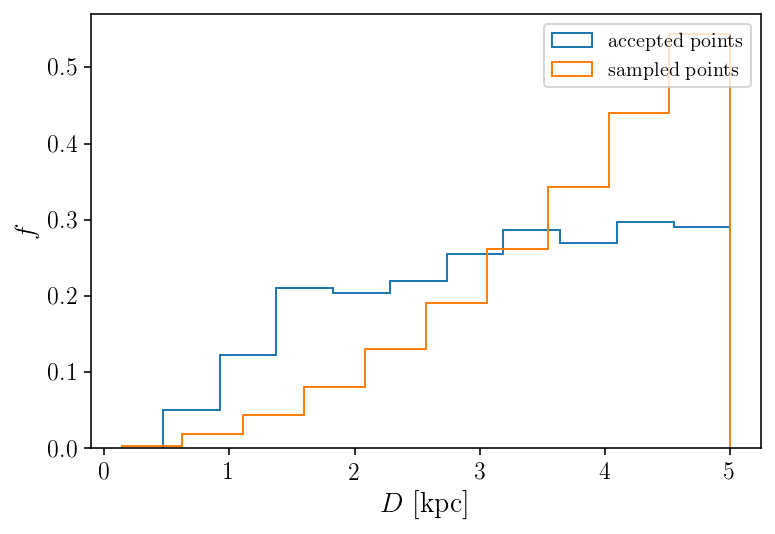

In [28]:
plt.hist(sample_d[accept], density=True, histtype='step', label=r'accepted points')
plt.hist(sample_d, density=True, histtype='step', label=r'sampled points')
plt.legend()
plt.xlabel(r'$D\ \mathrm{[kpc]}$')
plt.ylabel(r'$f$')

Notice how the dust changes the distance distribution quite a lot as well...

Can we accurately predict the mock data?

1654.2250252804386
1384


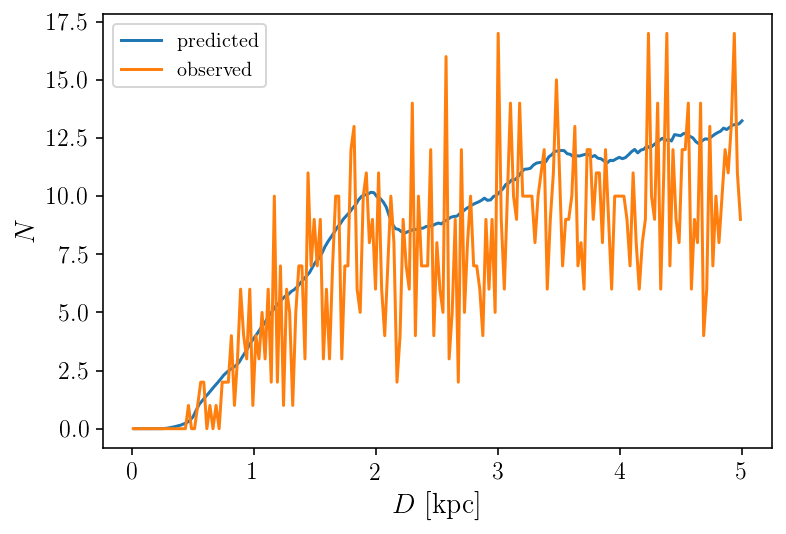

In [29]:
volume = V_field(ds, solid_angle)
vdiff = volume[1:]-volume[:-1]
plt.plot(ds[1:], eff_nodust[1:]*vdiff*meandens, label=r'predicted')
n, bins = np.histogram(sample_d[accept], bins=ds)
Vdiff = vols[1:]-vols[:-1]
rcenters = (ds[1:]+ds[:-1])/2.
#plt.axhline(meandens)
plt.plot(rcenters,n, label=r'observed')
print(np.sum(eff_nodust[1:]*vdiff*meandens))
print(sum(accept))
plt.xlabel(r'$D\ \mathrm{[kpc]}$')
plt.ylabel(r'$N$')
plt.legend()

Its noisy as hell, but looks good! Notice in this limit of very low counts in bins, we are much better served by thinking of this as an inhomogeneous poisson-point process!!!

Does the noisy data give a realisation of the effective selection, too?

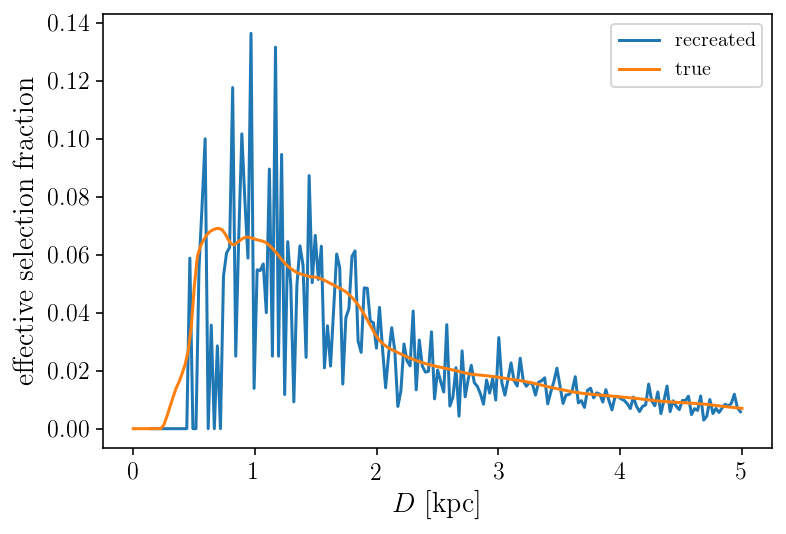

In [30]:
naccept, bins = np.histogram(sample_d[accept], bins=ds)
ntot, bins= np.histogram(sample_d, bins=ds)

plt.plot(rcenters, naccept/ntot, label=r'recreated')
plt.plot(ds, eff, label='true')


plt.xlabel(r'$D\ \mathrm{[kpc]}$')
plt.ylabel(r'effective selection fraction')
plt.legend()

and do we predict the mean density when we correct for the effective selection?

Text(0, 0.5, '$\\nu_*\\ \\mathrm{[stars\\ kpc^{-3}]}$')

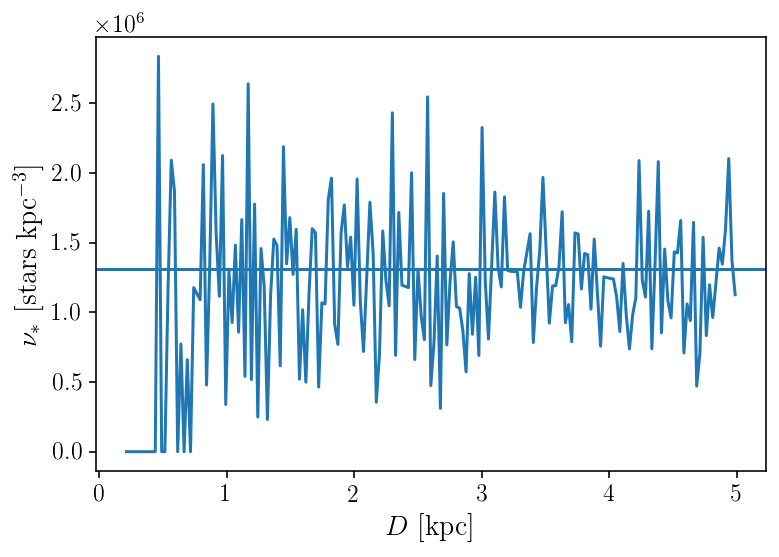

In [31]:
plt.plot(rcenters, n/(eff[1:]*vdiff))
plt.axhline(meandens)

plt.xlabel(r'$D\ \mathrm{[kpc]}$')
plt.ylabel(r'$\nu_*\ \mathrm{[stars\ kpc^{-3}]}$')


Looks like it! Nice!

Ok, now lets switch and use the real APOGEE selection function!

## A 'real' APOGEE field, and the real selection function

First, we need to get the selection function. If you havent already run this, it will take a long while....

In [32]:
if os.path.exists('../sav/apodr16_csf.dat'):
    with open('../sav/apodr16_csf.dat', 'rb') as f:
        apo = pickle.load(f)
else:
    apo = apsel.apogeeCombinedSelect(year=7)
    with open('../sav/apodr16_csf.dat', 'wb') as f:
        pickle.dump(apo, f)
        
# get the APOGEE fields included
locations = apo.list_fields()



In [33]:
Nsamp = 300000
Neffsamp = 2000

#pick one field and set the distance limit (and get the l,b of the field and its solid angle!)
dist = 5.
location_index = 887
loc = locations[location_index]
glonGlat = apo.glonGlat(loc)
solid_angle = apo.area(loc)*_DEGTORAD**2

#same mask
mask =  (isogrid['logg'] > 1) & (isogrid['logg'] < 3) & (isogrid['MH'] > -1.) & (isogrid['MH'] <= 0.5)

# sample for our mock data and a smaller set for the effective selection function (to speed things up!)
samples = iso.sampleiso(Nsamp, isogrid[mask], newgrid=True)
effsel_samples = iso.sampleiso(Neffsamp, isogrid[mask], newgrid=True)

#mean density again
meandens = Nsamp / V_field(dist,solid_angle)

#sample in this field
rands = sample_cone_spher(Nsamp, l=glonGlat[0][0], b=glonGlat[1][0], height=dist, solid_angle=solid_angle, return_spherical=True)
#convert to l b
sample_l, sample_b, sample_d = rands[:,2]*_RADTODEG, 90-rands[:,1]*_RADTODEG, rands[:,0]

#get the extinction
sample_ah = pixelate_and_get_extinction(sample_l, sample_b, sample_d,dmap)

#apply the extinction and compute magnitudes
sample_distmods = 5*np.log10(sample_d*1e3)-5
hmag_dust = samples['Hmag']+sample_distmods+sample_ah
jk_nodust = samples['Jmag']-samples['Ksmag']

#rejection sample from the selection function
accept = np.random.rand(len(hmag_dust)) < apo(loc, hmag_dust, jk_nodust)
sum(accept)/Nsamp

100%|██████████| 924/924 [00:59<00:00, 15.49it/s]


0.02188

Lets look at the selection function for this field:

Text(0.5, 0, '$(J-K_S)_0\\ \\mathrm{[mag]}$')

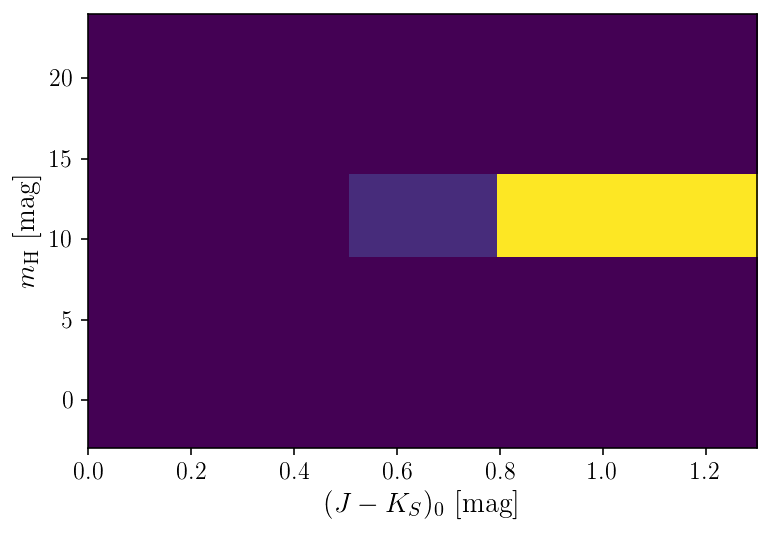

In [34]:

minm, maxm, minc, maxc, ng = -3, 24, 0., 1.3, 100
colourmaggrid = np.mgrid[minm:maxm:ng*1j, minc:maxc:ng*1j]
colourmaggrid = colourmaggrid.reshape(2,100*100).T


plt.imshow(apo(loc, colourmaggrid[:,0], colourmaggrid[:,1]).reshape(100,100), extent=[minc,maxc,minm,maxm], aspect='auto')
plt.ylabel(r'$m_\mathrm{H}\ \mathrm{[mag]}$')
plt.xlabel(r'$(J-K_S)_0\ \mathrm{[mag]}$')

Notice that this is somewhat simpler than our previous example. Most APOGEE fields look more like this, with a single bin in $H$ and a couple in colour, but they are a mixed bag, so we need to be careful!

Now we are using the `apogeeCombinedSelect` object, we can do the effective selection function calculation 'under the hood':

In [35]:
#initialise the effective selection function object, passing it the selection function, dustmap and isochrone samples:
apof = apsel.apogeeEffectiveSelect(apo, dmap3d=dmap, MH=effsel_samples['Hmag'], JK0=effsel_samples['Jmag']-effsel_samples['Ksmag'])
ds = np.linspace(0.01,dist,100)
apo_eff = apof(loc, ds)

make a quick plot to check:

Text(0, 0.5, 'effective selection fraction')

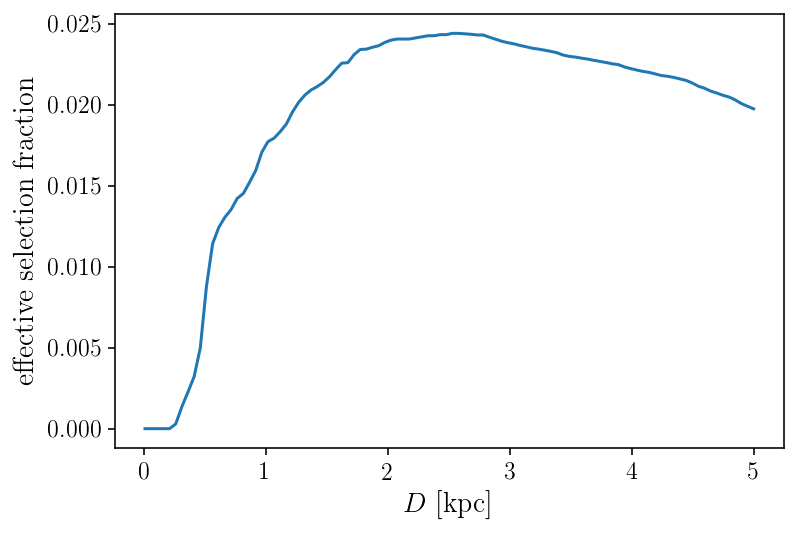

In [36]:

plt.plot(ds, apo_eff)
plt.xlabel(r'$D\ \mathrm{[kpc]}$')
plt.ylabel(r'effective selection fraction')

And finally, lets see if we can predict the true number counts:

Text(0, 0.5, '$N$')

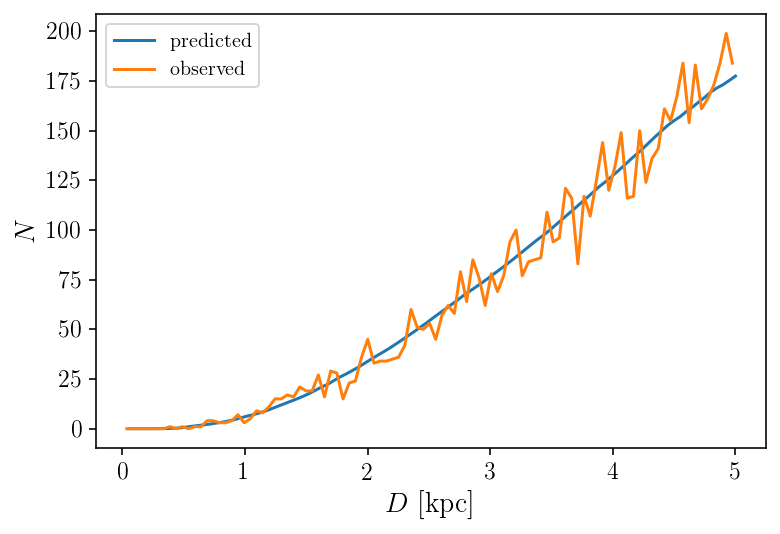

In [37]:
volume = V_field(ds, solid_angle)
vdiff = volume[1:]-volume[:-1]
plt.plot(ds[1:], apo_eff[1:]*vdiff*meandens, label=r'predicted')
n, bins = np.histogram(sample_d[accept], bins=ds)
Vdiff = vols[1:]-vols[:-1]
rcenters = (ds[1:]+ds[:-1])/2.
#plt.axhline(meandens)
plt.plot(rcenters,n, label='observed')
plt.legend()
plt.xlabel(r'$D\ \mathrm{[kpc]}$')
plt.ylabel(r'$N$')


In [38]:
print(sum(accept)/np.sum(apo_eff[1:]*vdiff*meandens))

0.9906734969842971


looks like we slightly underpredicted the counts, but not wildly - this is good!

In all of the above, we assumed that there was no variation in density with any observables (position or [Fe/H]). How could we include that in our mock data?

# What about variation with metallicity?

To account for metallicity dependence of the rate, we will need to do some more nifty rejection sampling. Lets dive in:

In [39]:
#load the selection function
if os.path.exists('../sav/apodr16_csf.dat'):
    with open('../sav/apodr16_csf.dat', 'rb') as f:
        apo = pickle.load(f)
else:
    apo = apsel.apogeeCombinedSelect(year=7)
    with open('../sav/apodr16_csf.dat', 'wb') as f:
        pickle.dump(apo, f)
        


def pixelate_and_get_extinction(sample_l, sample_b, sample_d, dmap):
    #highest resolution in the map
    maxnside = np.max(dmap._pix_info['nside'])
    #number of pixels in whole sky...
    npix = healpy.pixelfunc.nside2npix(maxnside)
    sample_pixels = healpy.pixelfunc.ang2pix(maxnside, sample_l, sample_b, lonlat=True)
    whichpix = np.unique(sample_pixels)
    distances = []
    sample_inds = []
    nbin = []
    bin_l, bin_b = healpy.pixelfunc.pix2ang(maxnside, whichpix, lonlat=True)
    extinction = np.zeros(len(sample_l))
    for i in tqdm.tqdm(range(len(whichpix))):
        mask = sample_pixels == whichpix[i]
        distances = sample_d[mask]
        ah = dmap(bin_l[i], bin_b[i], distances)
        extinction[mask] = ah  
    return extinction



Lets just consider a single field again, and assume that the density is again _spatially_ constant, but only at a given $\mathrm{[Fe/H]}$, and varies as a function of $\mathrm{[Fe/H]}$.

Lets make some random smoothly varying density as a function of [Fe/H]. We'll take random numbers at some fixed points and just draw a spline through (the model is smooth):

Text(0, 0.5, '$\\mathrm{relative\\ rate\\ [arbitary\\ unit]}$')

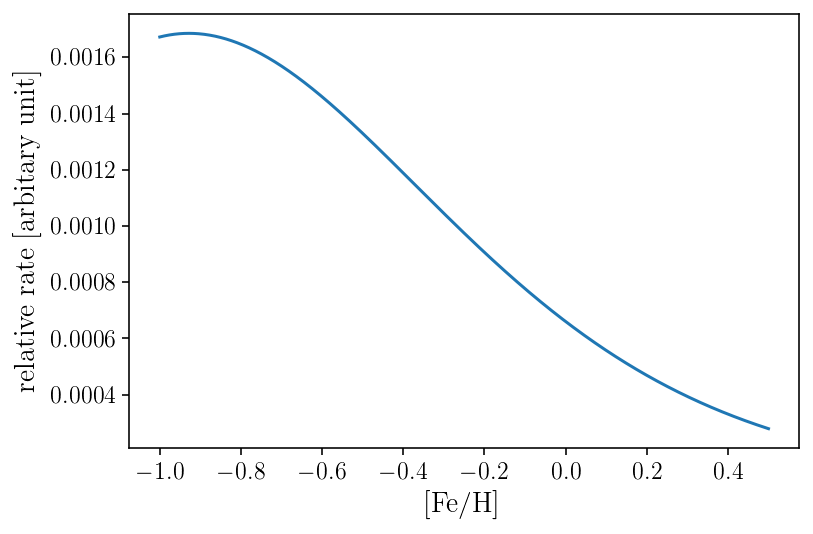

In [40]:
from scipy.interpolate import UnivariateSpline

#set 4 fixed points
fixed_points = np.linspace(-1,0.5,5)
uniform = False

#random numbers in log(density) - so that the density is always positive:
random_dens = np.random.randn(len(fixed_points))

#fit a spline
spline = UnivariateSpline(fixed_points, random_dens, k=3)
#plot the model:
newx = np.linspace(-1.,0.5,1000)
plt.plot(newx, np.exp(spline(newx))/np.sum(np.exp(spline(newx))))
plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$\mathrm{relative\ rate\ [arbitary\ unit]}$')

In [41]:
#pick a random field again:
locations = apo.list_fields()
location_index = 765
loc = locations[location_index]
glonGlat = apo.glonGlat(loc)
solid_angle = apo.area(loc)*_DEGTORAD**2

#set the number of samples, the maximum distance and compute the total field volume:
Nsamp = 100000
dist = 3
ds = np.linspace(0.001,dist,100)
vol = V_field(dist, solid_angle)

Text(0, 0.5, '$\\nu_*\\ \\mathrm{[star\\ dex^{-1}]}$')

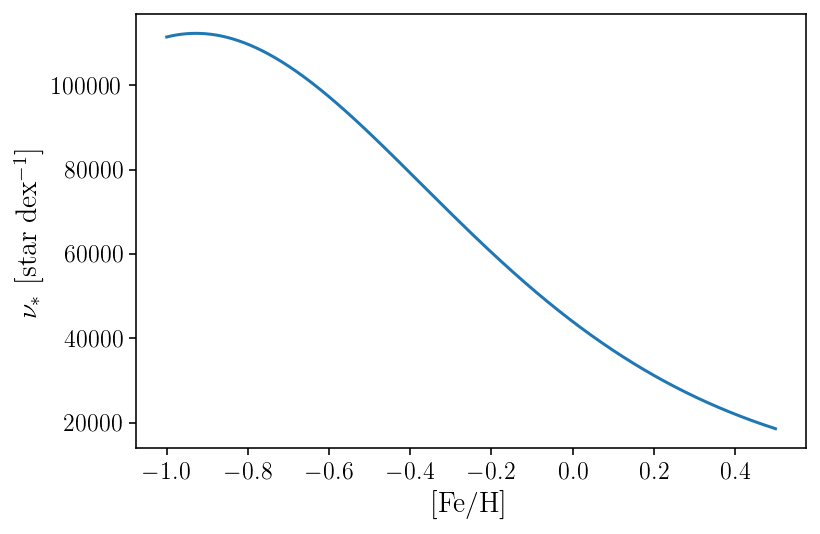

In [42]:
#integrate the spline to get the number of stars, for normalisation:
total_stars = quad(lambda x: np.exp(spline(x)), -1., 0.5)[0]
#compute a normalisation factor so that the total number of stars is correct
factor = Nsamp/total_stars

#set up functions for the rate and its integral
ratefn = lambda x: np.exp(spline(x))*factor
rate_ab = lambda a,b: quad(ratefn, a, b)[0]

#plot the rate in star dex^-1 (remember this is 'integrated' over the field volume!!)
plt.plot(newx, ratefn(newx))
plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$\nu_*\ \mathrm{[star\ dex^{-1}]}$')


Now we want to sample from the isochrones such that the [Fe/H] distribution matches the above target distribution. We can do this by rejection sampling (again!):

In [43]:


# a new mask - lets ignore isochrone points blueward of the minimum (J-K) of the field:
mask = (isogrid['MH'] > -1) & (isogrid['MH'] < 0.5) & (isogrid['logg'] > 1) & (isogrid['logg'] < 3) #& (isogrid['Jmag'] - isogrid['Ksmag'] > apo.JKmin(loc))

#set up the rejection sampling
maximum = np.max(ratefn(newx))*1.1
n_sampled = 0
iteration = 0
#keep iterating while the sampled points arent enough
while n_sampled < Nsamp:
    print(n_sampled) #print the current number of samples.
    #start with many samples
    tsamples = iso.sampleiso(Nsamp, isogrid[mask], newgrid=True)
    #test against the target distribution:
    accept = np.random.rand(Nsamp) < ratefn(tsamples['MH'])/maximum
    #keep the accepted samples
    if iteration == 0:
        samples = tsamples[accept]
    else:
        samples = np.concatenate([samples, tsamples[accept]])
    #add the number acceoted to the running total
    n_sampled += sum(accept)
    iteration += 1
#trim any extras!
samples = samples[:Nsamp]
print('%s points sampled' % len(samples))

0
55077
100000 points sampled


This converges quite quickly, which is good! Watch your memory if you take many samples!

does our sampled Fe/H distribution look ok?

100000


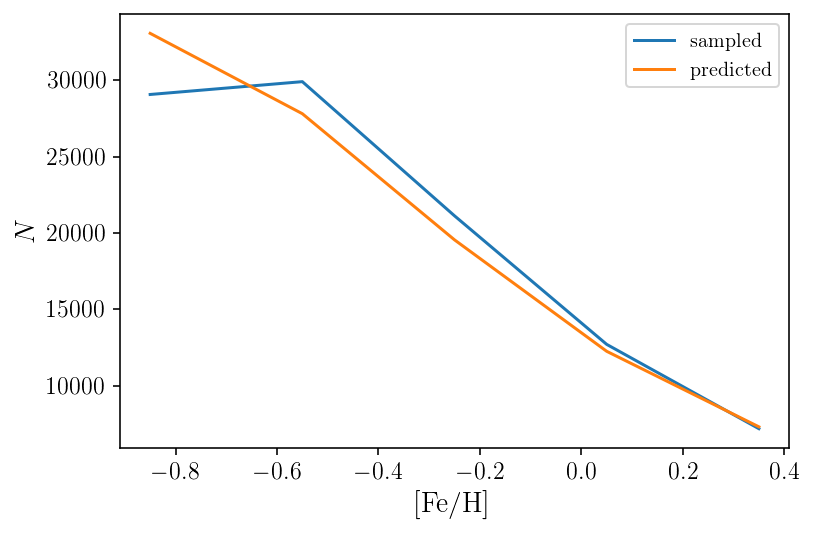

In [44]:
bins = np.linspace(-1.,0.5,6)
hist, bins = np.histogram(samples['MH'], bins=bins);
centers = (bins[1:]+bins[:-1])/2.
plt.plot(centers, hist, label=r'sampled')
print(sum(hist))
plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'N')
integral_rate = np.array([rate_ab(bins[i],bins[i+1]) for i in range(len(bins)-1)])
plt.plot(centers, integral_rate, label=r'predicted')
plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$N$')
plt.legend()

Its not too bad! Our Log(g) cut introduces a little bit of bias that affects the rejection sampling, but thats ok.

Now, for these samples, lets get the extinction and extract the magnitude information. Remember that the magnitude also depends on [Fe/H] - which is why we had to sample from the isochrones (so we get magnitudes consistent with the [Fe/H] distribution!!).

In [45]:

rands = sample_cone_spher(Nsamp, l=glonGlat[0][0], b=glonGlat[1][0], height=dist, solid_angle=solid_angle, return_spherical=True)

sample_l, sample_b, sample_d = rands[:,2]*_RADTODEG, 90-rands[:,1]*_RADTODEG, rands[:,0]

sample_ah = pixelate_and_get_extinction(sample_l, sample_b, sample_d,dmap)

100%|██████████| 656/656 [00:12<00:00, 52.15it/s]


In [46]:
sample_distmods = 5*np.log10(sample_d*1e3)-5
hmag_dust = samples['Hmag']+sample_distmods+sample_ah
jk_nodust = samples['Jmag']-samples['Ksmag']

accept = np.random.rand(len(hmag_dust)) < apo(loc, hmag_dust, jk_nodust)
sum(accept)/len(accept)

0.08648

What effect did the dust have?

Text(0, 0.5, '$N$')

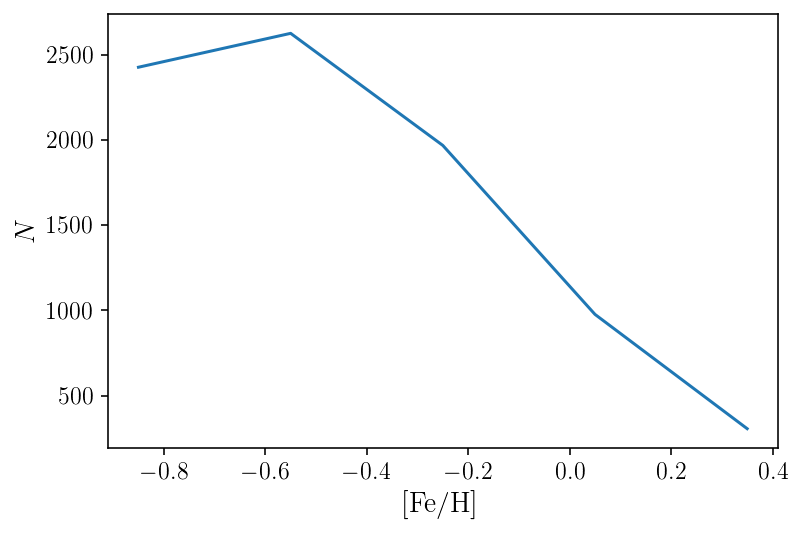

In [47]:
bins = np.linspace(-1.,0.5,6)

hist, bins = np.histogram(isodist.Z2FEH(samples['Z'][accept]), bins=bins);
centers = (bins[1:]+bins[:-1])/2.
plt.plot(centers, hist)
plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'N')
#plt.plot(newx, np.exp(spline(newx))*factor)
plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$N$')

essentially, the dust acts to remove stars at high metallicity (comparing to the above figure). These are the selection effects we really care about:

We can directly see what the selection does by comparing the accepted and not accepted samples (the reconstructed SF):

Text(0, 0.5, '$\\mathrm{reconstructed\\ selection\\ function}$')

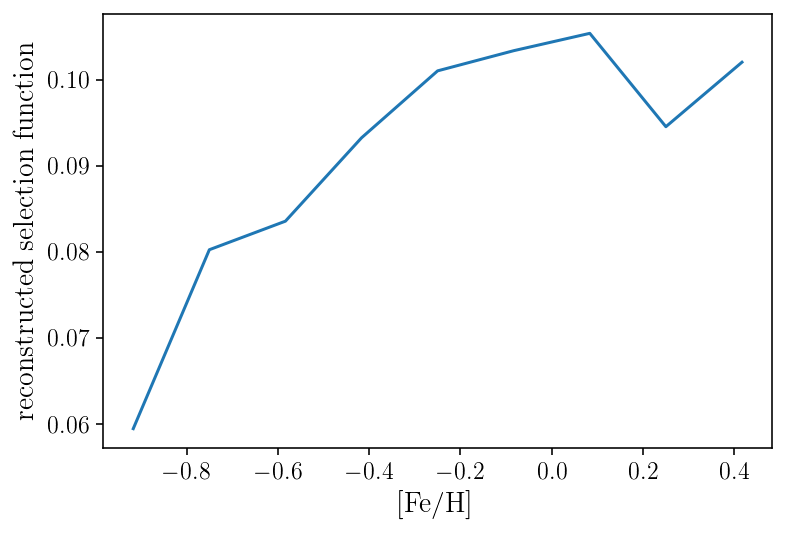

In [48]:
bins = np.linspace(-1.,0.5,10)

hist, bins = np.histogram(samples['MH'][accept], bins=bins);
allhist, bins = np.histogram(samples['MH'], bins=bins);
centers = (bins[1:]+bins[:-1])/2.
plt.plot(centers, hist/allhist)
plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'N')
#plt.plot(newx, np.exp(spline(newx))*factor)
plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$\mathrm{reconstructed\ selection\ function}$')


In reality, we see that the selection fraction is actually lower at low [Fe/H]!

Ok, so now what about the effective selection function? well now we have to compute it on a grid, since we dont have unlimited resolution in our stellar models. Lets see that done:

In [49]:
#number of samples to use for the effective selection:
Neffsamp = 3000

#distance and metallicity grid. The [Fe/H] grid needs to be coarse enough so that there is a few isochrones in each bin:
ds = np.linspace(0.001,dist,100)
fehbins = np.linspace(-1.,0.5,21)


effgrid = np.zeros((len(fehbins)-1,len(ds)))
jkmin = apo.JKmin(loc)

#loop and compute this in each bin of Fe/H
for i in tqdm.tqdm(range(len(fehbins)-1)):
    mask = (isogrid['logg'] > 1) & (isogrid['logg'] < 3) & (isogrid['MH'] > fehbins[i]) & (isogrid['MH'] < fehbins[i+1])
    effsel_samples = iso.sampleiso(Neffsamp, isogrid[mask], newgrid=True)
    apof = apsel.apogeeEffectiveSelect(apo, dmap3d=dmap, MH=effsel_samples['Hmag'], JK0=effsel_samples['Jmag']-effsel_samples['Ksmag'])
    effgrid[i] = apof(loc, ds)
    
print(np.mean(effgrid, axis=1))

100%|██████████| 20/20 [01:16<00:00,  3.80s/it]

[0.04191485 0.04934993 0.06172378 0.06654845 0.07029855 0.06976531
 0.06997404 0.07360797 0.08405489 0.08433252 0.08456655 0.08463074
 0.08468312 0.08409621 0.08470757 0.08479345 0.08453533 0.08490916
 0.08461352 0.08459179]


To predict the number counts, we need to integrate the rate in the fehbins and then divide that through by the bin size and the field volume (i.e. to get the true rate in stars kpc^-3 dex^-1).


In [50]:
# get mean density in each bin!
rate_integral = np.array([rate_ab(fehbins[i],fehbins[i+1]) for i in range(len(fehbins)-1)])
field_vol = V_field(dist,solid_angle)
density = rate_integral/field_vol/(fehbins[1]-fehbins[0])

Now by doing $\Omega \int{dD\ d\mathrm{[Fe/H]} D^{2} \nu_*([X,Y,Z](\mathrm{loc}, D), \mathrm{[Fe/H]})}$, we get the number counts as a function of Fe/H...

Text(0, 0.5, '$N$')

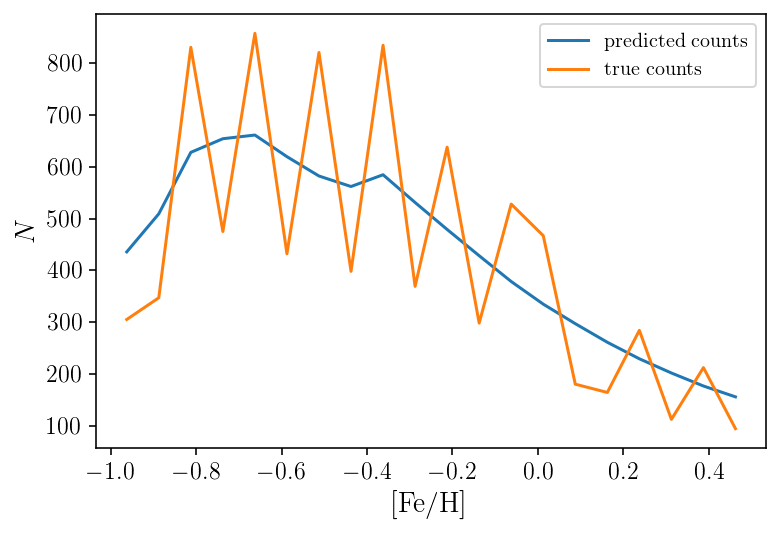

In [51]:
fehcenters = (fehbins[1:]+fehbins[:-1])/2.

#compute the predicted counts by doing the integral in distance
integral = np.sum(solid_angle*(effgrid.T*density).T*ds**2*(ds[1]-ds[0]), axis=1)*(fehbins[1]-fehbins[0])
plt.plot(fehcenters, integral, label=r'predicted counts')

#plot the true counts
hist, bins = np.histogram(samples['MH'][accept], bins=fehbins);
binc = (bins[1:]+bins[:-1])/2.
plt.plot(binc,hist, label=r'true counts')
plt.legend()
plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$N$')

This matches fairly well! the spikes are mainly due to the isochrone grid nodes... we could remove these by adding some gaussian blur to the metallicities we sampled?

We could also look at this in 2D (i.e. metallicity and distance):

Text(0.1, 0.1, 'mock data - model')

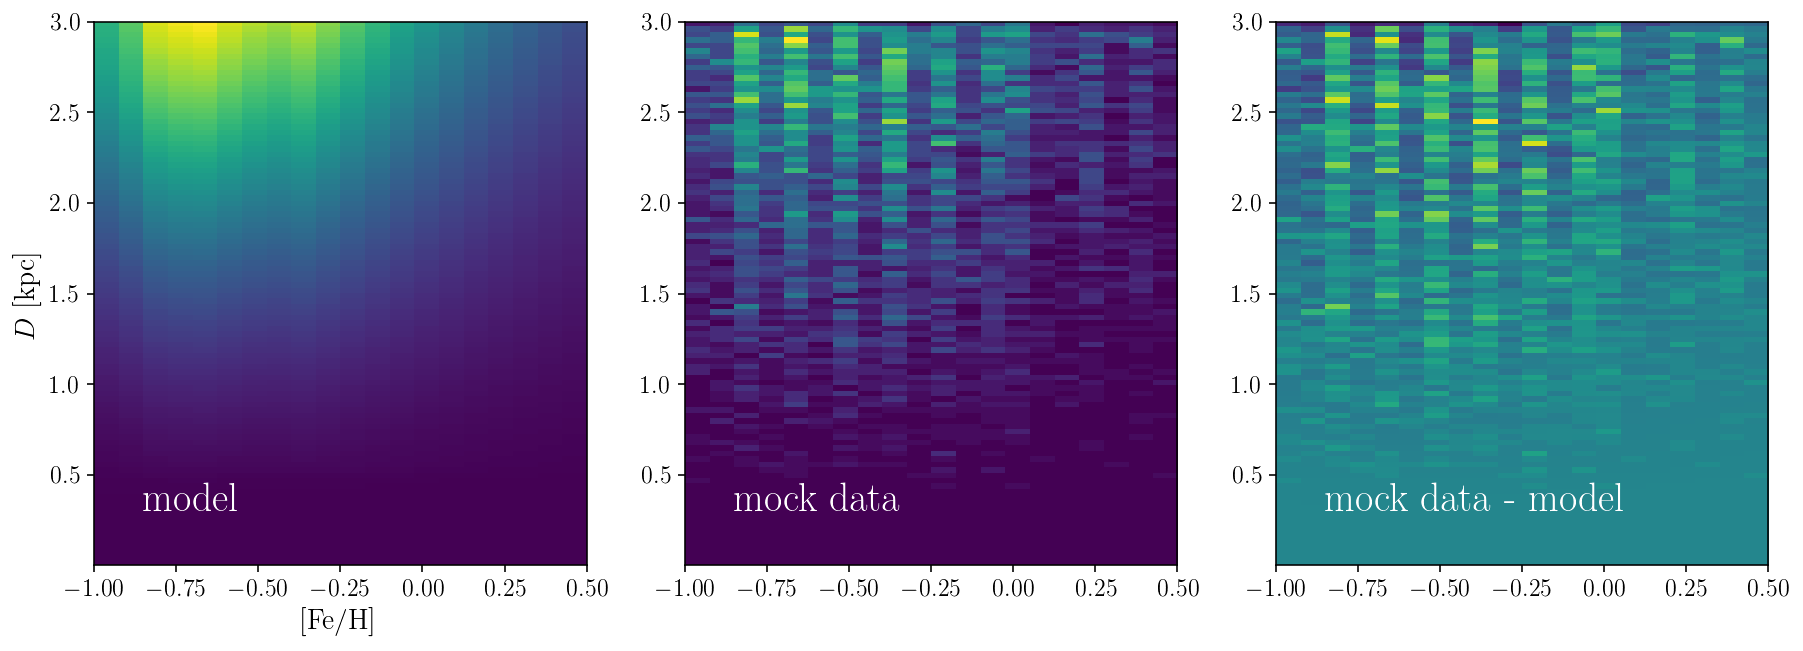

In [55]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(15,5)
ax[0].imshow(np.rot90(solid_angle*effgrid*ds**2*(ds[1]-ds[0]))*density*(fehbins[1]-fehbins[0]), extent=[fehbins[0],fehbins[-1], ds[0], ds[-1]], aspect='auto')
ax[0].set_xlabel(r'$\mathrm{[Fe/H]}$')
ax[0].set_ylabel(r'$D\ \mathrm{[kpc]}$')

ax[0].text(0.1,0.1,r'model', color='white', transform=ax[0].transAxes, fontsize=20)

dDs = ds[1]-ds[0]
dbins = np.arange(ds[0]-dDs/2.,ds[-1]+dDs, dDs)
hist, yedges, xedges = np.histogram2d(samples['MH'][accept], sample_d[accept], bins=[fehbins,dbins])
ax[1].imshow(np.rot90(hist), extent=[fehbins[0],fehbins[-1], ds[0], ds[-1]], aspect='auto')
ax[1].text(0.1,0.1,r'mock data', color='white', transform=ax[1].transAxes, fontsize=20)

predicted = np.rot90(solid_angle*effgrid*ds**2*(ds[1]-ds[0]))*density*(fehbins[1]-fehbins[0])

ax[2].imshow(np.rot90(hist)-predicted, aspect='auto', extent=[fehbins[0],fehbins[-1], ds[0], ds[-1]])
ax[2].text(0.1,0.1,r'mock data - model', color='white', transform=ax[2].transAxes, fontsize=20)



In [ ]:
plt.hist((np.rot90(hist)-predicted).ravel())
plt.xlabel(r'residual')
plt.ylabel(r'N')

In general, the residual between model and the mock data is small, and looks mostly like noise, which is good!!


From the above, you can see how we might be able to determine a smooth function that matches well the observed data, by simply optimising the rate function to predict the correct number of points.

We can do this by employing the poisson point process likelihood: $$\ln \mathcal{L}(\theta|O) = \sum_i{\lambda(O_i|\theta)} - \int{dO \ \lambda(O|\theta)}$$

The hard part is getting the second term right. In our case, this is made difficult by the need to use our complex selection function in this integral, which we can only really compute on quite a coarse grid...

what if we use a spline again?

In [ ]:
integral = np.sum(solid_angle*effgrid*ds**2*(ds[1]-ds[0]), axis=1)#*(fehbins[1]-fehbins[0])
effspline = UnivariateSpline(fehcenters, integral, k=4)

plt.plot(fehcenters, integral, label=r'binned')
plt.plot(fehcenters, effspline(fehcenters), label='spline')

plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$\mathcal{S}(\mathrm{[Fe/H]})\ \mathrm{[stars\ dex^{-1}]}$')
plt.legend()

now we could generate any 'smooth' function in [Fe/H] and predict the counts from it:

In [ ]:

total_n_stars = Nsamp

#set 4 fixed points
fixed_points = np.linspace(-1,0.5,5)
uniform = False

#random numbers in log(density) - so that the density is always positive:
random_dens = np.random.randn(len(fixed_points))

#fit a spline
ratespline = UnivariateSpline(fixed_points, random_dens, k=4)
ratefn = lambda x: np.exp(ratespline(x))
integ = quad(ratefn, -1, 0.5)[0]
factor = total_n_stars/integ
newratefn = lambda x: ratefn(x)*factor

#plot the model:
newx = np.linspace(-1.,0.5,1000)
plt.plot(newx, newratefn(newx))
plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$\lambda(\mathrm{[Fe/H]})\ \mathrm{[stars\ dex^{-1}]}$')
plt.scatter(fixed_points, np.exp(random_dens)*factor)

In [ ]:
obs_ratefn = lambda x: newratefn(x)*effspline(x)

#plot the model:
newx = np.linspace(-1.,0.5,1000)
plt.plot(newx, obs_ratefn(newx))
plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$\lambda_{\mathrm{obs}}(\mathrm{[Fe/H]})\ \mathrm{[stars\ dex^{-1}]}$')